In [3]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

%matplotlib inline

In [4]:
### Import get columns and rows
data = pd.read_csv("co2.csv",sep=',', comment='"',header=None)


In [5]:
def periodic(x, A=1, lambd=1, phi=0, sigma=0):
    '''
    A periodic triangle function with specified amplitude, frequency, phase,
    and optional noise added to the function value.

    Inputs:

        x (float or array): The input value(s) at which to evaluate the
          function.

        A (float): The amplitude of the function. The non-noisy function
          value will vary from -A to A. Default: 1.

        lambda (float): The frequency of the function. There will will be
          lambda waves per unit of `x`. Default: 1.

        phi (float): The phase offset of the function. The graph of the
          function moves to the left by this many waves. Note that `phi`
          is periodic in the range [0, 1], so setting `phi = 1.2` will
          have the same effect as setting `phi = 0.2` or `phi = `2.2`.
          Default: 0.

        sigma (float): The amount of noise to add to the function value,
          interpreted as the standard deviation of zero-mean Gaussian
          noise. Default: 0.

    Returns: (float or array) matching the dimensions of `x` with the
      periodic function values.
    '''
    return (
        A * (4 * abs((lambd * x + phi) % 1 - 0.5) - 1) +
        stats.norm.rvs(0, sigma, size=np.shape(x)))

plot_x = np.linspace(0, 5, 501)
plt.figure(figsize=(12, 6))
plt.plot(plot_x, periodic(plot_x))
plt.title('The standard form of the periodic function')
plt.show()

NameError: name 'curly' is not defined

<Figure size 864x432 with 0 Axes>

In [ ]:
1/46

In [ ]:
import math

def guess(xlist):
    ret = []
    for x in xlist:
        # A * (4 * fabs(fmod(lambda * t + phi, 1) - 0.5) - 1)
        poly = 316 + 0.015*x +0.000005*x**2
        curly = periodic(x, A=3, lambd=1/46, phi=0.9, sigma=0.2)
        ret.append(poly+curly)
    return(ret)

In [ ]:
xshort = [x for x in range(400)]

plt.plot(xshort,data.loc[:399][1]);
plt.plot(xshort,guess(xshort));

plt.show();

In [ ]:
tx = [x for x in range(3139)]
plt.plot(tx,data.loc[:][1]);
plt.plot(tx,guess(tx),alpha=0.5);
plt.show();

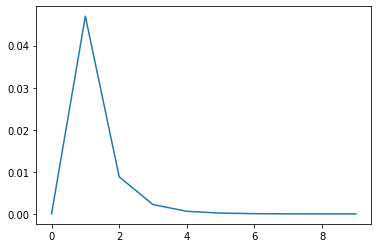

In [130]:


plt.plot([x for x in range(10)],[stats.gamma.pdf(x,0.1,0.1) for x in range(10)]);
plt.show();

In [15]:
# setup model data

n = 1500
n_future = 3139 - n


In [16]:
stan_data = {
    'n': n,
    'n_future': n_future,
    'x': data.loc[:n-1][1]}  # Stan gets to see the first n data values only


Note on the model

It should be roughly linear, with sinusoidal noise.

        poly = 316 + 0.015*x +0.000005*x**2
        curly = periodic(x, A=3, lambd=1/46, phi=0.9, sigma=0.2)


In [166]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time.

stan_code = """
data {
    int<lower=0> n;        // The number of data
    real x[n];             // The data
    int<lower=0> n_future; // The number of future values to predict
}

parameters {
    // ___ FOR POLY ___
    real C1;                // constant
    real C2;                // x multiplier
    real C3;                // x^2 multiplier
    
    // ___ FOR PERIODIC ___
    real<lower=0> A;        // amplitude
    real<lower=0> lambda;   // frequency

    // We need a periodic phi
    real phi_x;             // x offset
    real phi_y;             // y offset
    
    // ___ MORE NOISE ___
    real<lower=0,upper=1> sigma;    // deviation

}

transformed parameters {
    real<lower=0,upper=1> phi;

    // The atan2 function returns a value in the range [-pi, pi], which we
    // then transform linearly into the range [0, 1].
    phi = (atan2(phi_x, phi_y) / (2 * pi()) + 0.5);
}

model {
    A ~ normal(3, 1);
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    C1 ~ normal(310, 100);       // uncertain
    C2 ~ normal(0,1);        // uncertain
    C3 ~ normal(0,1);    // uncertain
    sigma ~ gamma(1, 0.3);
    for(t in 1:n) {
        x[t] ~ normal(
            C1 + C2*t + C2*t^2 + A * (4 * fabs(fmod(lambda * t + phi, 1) - 0.5) - 1),
            sigma);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(t in 1:n_future) {
        x_future[t] = normal_rng(
            C1 + C2*t + C2*t^2+ A * (4 * fabs(fmod(lambda * t + phi, 1) - 0.5) - 1),
            sigma);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

ValueError: Failed to parse Stan model 'anon_model_79b10b4ae7c0d97b4e04c9a401755892'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:
Illegal statement beginning with non-void expression parsed as
  sigma
Not a legal assignment, sampling, or function statement.  Note that
  * Assignment statements only allow variables (with optional indexes) on the left;
  * Sampling statements allow arbitrary value-denoting expressions on the left.
  * Functions used as statements must be declared to have void returns

 error in 'unknown file name' at line 58, column 12
  -------------------------------------------------
    56:             C1 + C2*t + C2*t^2,sigma);
    57:             // + A * (4 * fabs(fmod(lambda * (t + n) + phi, 1) - 0.5) - 1),
    58:             sigma
                   ^
    59:     }
  -------------------------------------------------

PARSER EXPECTED: "}"


In [ ]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['C1','C2','C3','A', 'lambda', 'phi', 'sigma'] #,'A', 'lambda', 'phi', 'sigma'

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

In [2]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

NameError: name 'parameters' is not defined

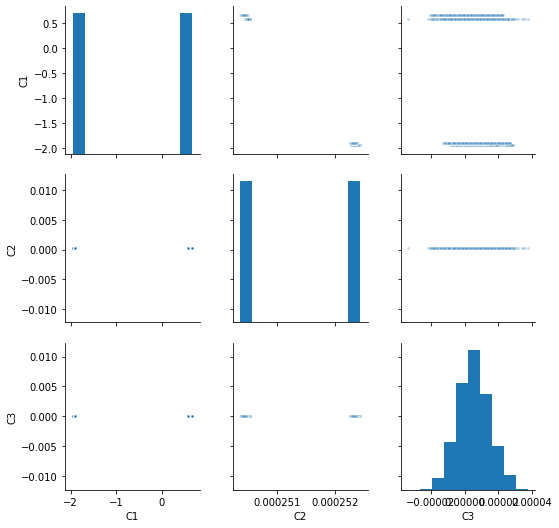

In [168]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

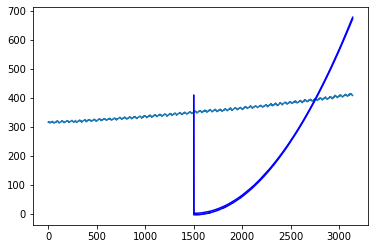

In [169]:
#'C1','C2','C3','A', 'lambda', 'phi', 'sigma'
pi_c1 = np.percentile(samples["C1"], axis=0, q=[2.5, 97.5])
pi_c2 = np.percentile(samples["C2"], axis=0, q=[2.5, 97.5])
pi_c3 = np.percentile(samples["C3"], axis=0, q=[2.5, 97.5])
pi_A = np.percentile(samples["A"], axis=0, q=[2.5, 97.5])
pi_L = np.percentile(samples["lambda"], axis=0, q=[2.5, 97.5])
pi_P = np.percentile(samples["phi"], axis=0, q=[2.5, 97.5])
pi_S = np.percentile(samples["sigma"], axis=0, q=[2.5, 97.5])

import math
'''

import math

def guess(xlist):
    ret = []
    for x in xlist:
        # A * (4 * fabs(fmod(lambda * t + phi, 1) - 0.5) - 1)
        poly = 316 + 0.015*x +0.000005*x**2
        curly = periodic(x, A=3, lambd=1/46, phi=0.9, sigma=0.2)
        ret.append(poly+curly)
    return(ret)
    
    '''
pL = []
pU = []
# A * (4 * fabs(fmod(lambda * t + phi, 1) - 0.5) - 1)
for t in range(N):
    #A * (4 * abs((lambd * x + phi) % 1 - 0.5) - 1)
    pL.append(stats.norm.rvs(pi_c1[0] + pi_c2[0]*t + pi_c3[0]*t**2 + pi_A[0]*math.cos((2*math.pi*t)/362.5 + pi_c3[0]), pi_c4[0]))
    pU.append(stats.norm.rvs(pi_c1[1] + pi_c2[1]*t + pi_c3[1]*t**2 + pi_A[1]*math.cos((2*math.pi*t)/362.5 + pi_c3[1]), pi_c4[1]))

    

In [170]:
samples['x_future']

array([[-1.77313077e+00, -1.22099938e+00, -5.26402771e-01, ...,
         6.73822403e+02,  6.73873858e+02,  6.76538028e+02],
       [-1.74201798e+00, -3.29680801e-01, -1.44342863e+00, ...,
         6.74127789e+02,  6.76858468e+02,  6.76528789e+02],
       [-1.64550621e+00, -2.04892113e+00, -2.00416782e+00, ...,
         6.75121428e+02,  6.75566213e+02,  6.75868972e+02],
       ...,
       [-1.88374996e+00, -3.02849833e+00, -2.82452115e+00, ...,
         6.75107457e+02,  6.75942681e+02,  6.76409610e+02],
       [-8.43892674e-01, -9.74166690e-01, -2.70264577e+00, ...,
         6.76125390e+02,  6.76398126e+02,  6.76171584e+02],
       [-3.14866158e+00, -2.22246310e+00, -1.31182408e+00, ...,
         6.75027836e+02,  6.73851764e+02,  6.76241691e+02]])

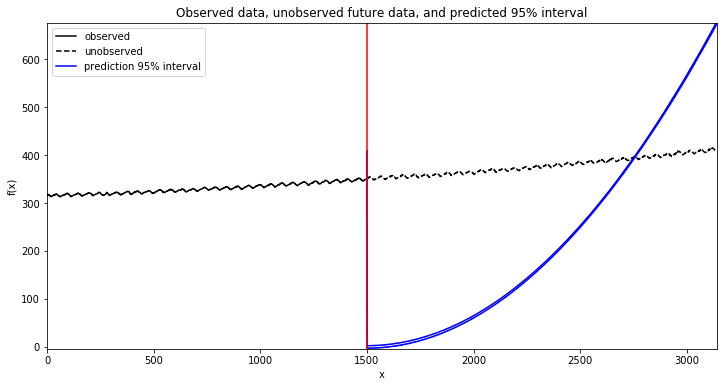

In [171]:
prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, n + 1), data[:n][1], 'k-', label='observed')
plt.plot(range(n, n + n_future + 1), data[n-1:][1], 'k--', label='unobserved')
plt.xlim(0, n + n_future + 1)
plt.ylim(
    min(min(prediction[0,:]), min(data)),
    max(max(prediction[1,:]), max(data)))
plt.plot(
    range(n, n + n_future + 1),
    np.concatenate((data[-1:][1], prediction_interval[0,:])),
    'b-', label='prediction 95% interval')
plt.plot(
    range(n, n + n_future + 1),
    np.concatenate((data[-1:][1], prediction_interval[1,:])),
    'b-')
plt.axvline(n - 1, color='red')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()